<a href="https://colab.research.google.com/github/Nikhisl/lstmonlinetrain/blob/main/bilstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()  # Upload your kaggle.json here


TypeError: 'NoneType' object is not subscriptable

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d banudeep/nthuddd2
!unzip nthuddd2.zip -d /content/nthu


In [ ]:
from google.colab import files
uploaded = files.upload()  # Choose your db_annotations.zip here


In [ ]:
import zipfile
import os

zip_path = "/content/db_annotations.zip"  # or replace with exact name if different
extract_path = "/content/biwi_headpose_data"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"✅ Extracted BIWI dataset to: {extract_path}")


In [ ]:
import os
import struct
import pandas as pd

def read_head_pose(bin_path):
    with open(bin_path, 'rb') as f:
        data = f.read()
        pose = struct.unpack('fff', data[:12])  # pitch, yaw, roll
    return pose

pose_data = []
base_path = "/content/biwi_headpose_data"

for subject in sorted(os.listdir(base_path)):
    subject_path = os.path.join(base_path, subject)
    if not os.path.isdir(subject_path):
        continue

    for seq in sorted(os.listdir(subject_path)):
        seq_path = os.path.join(subject_path, seq, "frameAnnotations", "groundTruth.txt")
        if not os.path.exists(seq_path):
            continue

        with open(seq_path, "r") as f:
            for line in f:
                if line.strip() == "":
                    continue
                frame_name = line.split()[0].split('/')[-1].replace(".png", "")
                bin_file = os.path.join(subject_path, seq, "frameAnnotations", "Pose", f"{frame_name}.pose.txt")
                if not os.path.exists(bin_file):
                    continue
                try:
                    pitch, yaw, roll = read_head_pose(bin_file)
                    image_name = f"{subject}/{seq}/{frame_name}.png"
                    pose_data.append([image_name, pitch, yaw, roll])
                except:
                    continue

# ✅ Ensure directory exists
os.makedirs("/content/headpose_data", exist_ok=True)

# Save to CSV
df_pose = pd.DataFrame(pose_data, columns=["image", "pitch", "yaw", "roll"])
df_pose.to_csv("/content/headpose_data/head_pose_labels.csv", index=False)

print("✅ Head pose CSV saved at: /content/headpose_data/head_pose_labels.csv")


In [ ]:
from google.colab import files
files.download("/content/headpose_data/head_pose_labels.csv")


In [ ]:
import pandas as pd

# ⚠️ all_keypoints_data should be in memory (each item: image, pitch, yaw, roll, kpt_0..520, label)
# If not, you may need to re-run the keypoint extraction script first

# Example only if `all_keypoints_data` exists
try:
    output = all_keypoints_data  # or rename if your variable is different

    # Prepare column names
    num_kpts = len(output[0]) - 5  # 5: image, pitch, yaw, roll, label
    columns = ["image", "pitch", "yaw", "roll"] + [f"kpt_{i}" for i in range(num_kpts)] + ["label"]

    # Convert and save
    df_out = pd.DataFrame(output, columns=columns)
    df_out.to_csv("/content/nthu_keypoints.csv", index=False)
    print("✅ Saved to /content/nthu_keypoints.csv")

except Exception as e:
    print("❌ Could not save: `all_keypoints_data` not found or malformed")
    print(f"Error: {e}")


In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload the NTHU zip


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d banudeep/nthuddd2
!unzip nthuddd2.zip -d /content/nthu_data


In [ ]:
!pip install mediapipe --quiet


In [ ]:
import cv2
import mediapipe as mp
import pandas as pd
import os

mp_pose = mp.solutions.pose.Pose()
mp_hands = mp.solutions.hands.Hands()
mp_face = mp.solutions.face_mesh.FaceMesh()

def extract_mediapipe_keypoints(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results_pose = mp_pose.process(image_rgb)
    results_hands = mp_hands.process(image_rgb)
    results_face = mp_face.process(image_rgb)

    keypoints = []

    # Pose (33 landmarks)
    if results_pose.pose_landmarks:
        keypoints += [coord for lm in results_pose.pose_landmarks.landmark for coord in (lm.x, lm.y, lm.z)]
    else:
        keypoints += [0]*99

    # Hands (left + right = 42 landmarks)
    for hand in [results_hands.multi_hand_landmarks] if results_hands.multi_hand_landmarks else [None, None]:
        if hand:
            keypoints += [coord for lm in hand[0].landmark for coord in (lm.x, lm.y, lm.z)]
        else:
            keypoints += [0]*63

    # Face (468 landmarks)
    if results_face.multi_face_landmarks:
        keypoints += [coord for lm in results_face.multi_face_landmarks[0].landmark for coord in (lm.x, lm.y, lm.z)]
    else:
        keypoints += [0]*1404

    return keypoints

all_keypoints_data = []

# Update this path based on actual folder names
data_path = "/content/nthu_data"
label_dict = {"drowsy": 1, "notdrowsy": 0}

for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".jpg") or file.endswith(".png"):
            full_path = os.path.join(root, file)
            label = 1 if "drowsy" in full_path.lower() else 0
            kpts = extract_mediapipe_keypoints(full_path)
            if kpts:
                all_keypoints_data.append([file, 0, 0, 0] + kpts + [label])  # dummy pitch/yaw/roll for now

print(f"✅ Total samples extracted: {len(all_keypoints_data)}")


In [ ]:
import pandas as pd

# Check one sample to see how many features
sample_len = len(all_keypoints_data[0])
print(f"📏 Total columns per row: {sample_len}")

# Columns: image + pitch + yaw + roll + keypoints + label
keypoint_count = sample_len - 5  # excluding image, pitch, yaw, roll, label

# Now build column names dynamically
columns = ["image", "pitch", "yaw", "roll"] + [f"kpt_{i}" for i in range(keypoint_count)] + ["label"]

# Convert to DataFrame
df_nthu_kpt = pd.DataFrame(all_keypoints_data, columns=columns)

# Save to CSV
df_nthu_kpt.to_csv("/content/nthu_keypoints.csv", index=False)
print("✅ Saved NTHU keypoints to: /content/nthu_keypoints.csv")

In [ ]:
from google.colab import files
files.download("/content/nthu_keypoints.csv")


In [ ]:
import zipfile

# Extract faces zip
zip_path_faces = "/content/drive/MyDrive/facespose.zip"
extract_path_faces = "/content/facespose"
with zipfile.ZipFile(zip_path_faces, 'r') as zip_ref:
    zip_ref.extractall(extract_path_faces)

# Extract annotations zip
zip_path_annot = "/content/drive/MyDrive/db_annotationsfile.zip"
extract_path_annot = "/content/db_annotationsfile"
with zipfile.ZipFile(zip_path_annot, 'r') as zip_ref:
    zip_ref.extractall(extract_path_annot)

print("✅ Extracted both zip files successfully!")


✅ Extracted both zip files successfully!


In [ ]:
import os

print("✅ Checking faces_subset structure:")
print(os.listdir("/content/facespose")[:5])  # should show folders like '1', '2', ...

print("✅ Checking db_annotations structure:")
print(os.listdir("/content/db_annotationsfile")[:5])


✅ Checking faces_subset structure:
['07.obj', '10', '06.obj', '10.obj', '01']
✅ Checking db_annotations structure:
['10', '01', '05', '04', '03']


In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation as R

def extract_pose_from_file(pose_path):
    with open(pose_path, 'r') as f:
        lines = f.readlines()
        matrix = []
        for line in lines:
            numbers = list(map(float, line.strip().split()))
            matrix.append(numbers)
        matrix = np.array(matrix[:3])  # 3x4 matrix
        rotation_matrix = matrix[:, :3]
        r = R.from_matrix(rotation_matrix)
        pitch, yaw, roll = r.as_euler('xyz', degrees=True)
        return pitch, yaw, roll

def extract_head_pose_labels_biwi(base_dir):
    pose_data = []
    subjects = sorted(os.listdir(base_dir))

    for subj in subjects:
        subj_path = os.path.join(base_dir, subj)
        if not os.path.isdir(subj_path):
            continue

        files = sorted(os.listdir(subj_path))
        for file in files:
            if file.endswith("_rgb.png"):
                image_path = os.path.join(subj, file)
                pose_file = file.replace("_rgb.png", "_pose.txt")
                pose_path = os.path.join(subj_path, pose_file)

                if not os.path.exists(pose_path):
                    continue

                try:
                    pitch, yaw, roll = extract_pose_from_file(pose_path)
                    pose_data.append([image_path, pitch, yaw, roll])
                except:
                    print(f"⚠️ Skipped corrupted or unreadable file: {pose_path}")
                    continue

    return pose_data

# Extract
pose_data = extract_head_pose_labels_biwi("/content/facespose")

# Save
os.makedirs("/content/headpose_data", exist_ok=True)
df_pose = pd.DataFrame(pose_data, columns=["image", "pitch", "yaw", "roll"])
df_pose.to_csv("/content/headpose_data/head_pose_labels.csv", index=False)

print(f"✅ Head pose CSV saved successfully with {len(df_pose)} records!")


✅ Head pose CSV saved successfully with 7097 records!


In [ ]:
from google.colab import files
files.download("/content/headpose_data/head_pose_labels.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_pose = pd.read_csv("/content/headpose_data/head_pose_labels.csv")
df_kpt = pd.read_csv("/content/nthu_keypoints.csv")

# Merge on image column
df_merged = pd.merge(df_kpt, df_pose, on='image', how='inner')  # or 'left'

# Save merged CSV
df_merged.to_csv("/content/merged_driver_data.csv", index=False)
print("✅ Merged dataset saved!")


✅ Merged dataset saved!


In [ ]:
from google.colab import files
files.download("/content/merged_driver_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
import shutil
import os

# Define source and destination paths
drive_head_pose_path = '/content/drive/MyDrive/head_pose_labels (3).csv'
colab_head_pose_dir = '/content/headpose_data'
colab_head_pose_path = os.path.join(colab_head_pose_dir, 'head_pose_labels.csv')

drive_nthu_path = '/content/drive/MyDrive/nthu_keypoints.csv'
colab_nthu_path = '/content/nthu_keypoints.csv'

# Ensure the target directory exists for head_pose_labels.csv
os.makedirs(colab_head_pose_dir, exist_ok=True)

try:
    # Copy the head pose labels file
    shutil.copy(drive_head_pose_path, colab_head_pose_path)
    print(f"✅ Copied '{drive_head_pose_path}' to '{colab_head_pose_path}'")

    # Copy the nthu keypoints file
    shutil.copy(drive_nthu_path, colab_nthu_path)
    print(f"✅ Copied '{drive_nthu_path}' to '{colab_nthu_path}'")

except FileNotFoundError as e:
    print(f"❌ Error: {e}. Please ensure the files exist in your Google Drive at the specified paths.")
except Exception as e:
    print(f"❌ An unexpected error occurred: {e}")

✅ Copied '/content/drive/MyDrive/head_pose_labels (3).csv' to '/content/headpose_data/head_pose_labels.csv'
✅ Copied '/content/drive/MyDrive/nthu_keypoints.csv' to '/content/nthu_keypoints.csv'


In [9]:
import pandas as pd

# Load both files
biwi_df = pd.read_csv('/content/headpose_data/head_pose_labels.csv')
nthu_df = pd.read_csv('/content/nthu_keypoints.csv')

# Make sure both have same columns
print("BIWI Columns:", biwi_df.columns.tolist())
print("NTHU Columns:", nthu_df.columns.tolist())

# Merge
combined_df = pd.concat([biwi_df, nthu_df], ignore_index=True)

# Save combined CSV
combined_df.to_csv('/content/combined_keypoints.csv', index=False)
print("✅ Combined dataset saved.")


BIWI Columns: ['image', 'pitch', 'yaw', 'roll']
NTHU Columns: ['image', 'pitch', 'yaw', 'roll', 'kpt_0', 'kpt_1', 'kpt_2', 'kpt_3', 'kpt_4', 'kpt_5', 'kpt_6', 'kpt_7', 'kpt_8', 'kpt_9', 'kpt_10', 'kpt_11', 'kpt_12', 'kpt_13', 'kpt_14', 'kpt_15', 'kpt_16', 'kpt_17', 'kpt_18', 'kpt_19', 'kpt_20', 'kpt_21', 'kpt_22', 'kpt_23', 'kpt_24', 'kpt_25', 'kpt_26', 'kpt_27', 'kpt_28', 'kpt_29', 'kpt_30', 'kpt_31', 'kpt_32', 'kpt_33', 'kpt_34', 'kpt_35', 'kpt_36', 'kpt_37', 'kpt_38', 'kpt_39', 'kpt_40', 'kpt_41', 'kpt_42', 'kpt_43', 'kpt_44', 'kpt_45', 'kpt_46', 'kpt_47', 'kpt_48', 'kpt_49', 'kpt_50', 'kpt_51', 'kpt_52', 'kpt_53', 'kpt_54', 'kpt_55', 'kpt_56', 'kpt_57', 'kpt_58', 'kpt_59', 'kpt_60', 'kpt_61', 'kpt_62', 'kpt_63', 'kpt_64', 'kpt_65', 'kpt_66', 'kpt_67', 'kpt_68', 'kpt_69', 'kpt_70', 'kpt_71', 'kpt_72', 'kpt_73', 'kpt_74', 'kpt_75', 'kpt_76', 'kpt_77', 'kpt_78', 'kpt_79', 'kpt_80', 'kpt_81', 'kpt_82', 'kpt_83', 'kpt_84', 'kpt_85', 'kpt_86', 'kpt_87', 'kpt_88', 'kpt_89', 'kpt_90', 'kpt

In [10]:
# Reload combined CSV
df = pd.read_csv("/content/combined_keypoints.csv")

# Drop rows with missing labels safely
df = df.dropna(subset=['label']).copy()

# Convert label to int
df['label'] = df['label'].astype(int)

print("✅ Cleaned data shape:", df.shape)
print("✅ Unique labels:", df['label'].unique())


✅ Cleaned data shape: (66320, 1634)
✅ Unique labels: [1 0]


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [12]:
import numpy as np
print("Unique labels:", np.unique(y_train))
print("Any NaNs in labels?", np.isnan(y_train).sum())


Unique labels: [0 1]
Any NaNs in labels? 0


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input
from keras.callbacks import EarlyStopping
import tensorflow as tf

# ✅ Step 1: Load only first and last 10,000 rows
df = pd.read_csv("/content/combined_keypoints.csv")  # Your combined CSV
df = pd.concat([df.iloc[:10000], df.iloc[-10000:]]).reset_index(drop=True)

# ✅ Step 2: Clean any NaNs if present
df = df.dropna()
df['label'] = df['label'].astype(int)

# ✅ Step 3: Split X, y
X = df.drop(columns=["label", "image"]).values.reshape(df.shape[0], 1, -1)  # LSTM shape
y = df['label'].values

# ✅ Step 4: Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(X.shape[0], -1)).reshape(X.shape)

# ✅ Step 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ✅ Step 6: Compute class weights
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))
print("Class Weights:", class_weights)

# ✅ Step 7: Build LSTM model
model = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# ✅ Step 8: Train model
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

# ✅ Step 9: Save model
model.save("driver_drowsiness_lstm_balanced.h5")
print("✅ Model saved!")


Class Weights: {0: np.float64(0.6455839737936248), 1: np.float64(2.2172219818260492)}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │       901,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 953,409 (3.64 MB)

 Trainable params: 953,281 (3.64 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.4538 - loss: 0.7392 - val_accuracy: 0.7745 - val_loss: 0.6759
Epoch 2/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.5113 - loss: 0.7091 - val_accuracy: 0.7745 - val_loss: 0.6644
Epoch 3/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.5256 - loss: 0.6834 - val_accuracy: 0.7850 - val_loss: 0.6410
Epoch 4/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5221 - loss: 0.6820 - val_accuracy: 0.7831 - val_loss: 0.5946
Epoch 5/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.5312 - loss: 0.6711 - val_accuracy: 0.7456 - val_loss: 0.5272
Epoch 6/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.5409 - loss: 0.6647 - val_accuracy: 0.3890 - val_loss: 0.6958
Epoch 7/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.5760 - loss: 0.6563 - val_accuracy: 0.7901 - val_loss: 0.5168
Epoch 8/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.5468 - loss: 0.6560 - val_ac

✅ Model saved!


In [6]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.2f} | Loss: {loss:.2f}")


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7997 - loss: 0.5128
Test Accuracy: 0.79 | Loss: 0.52


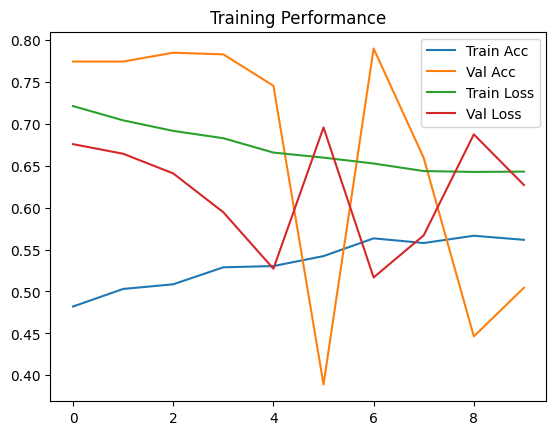

In [7]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training Performance")
plt.show()


In [8]:
y_pred = model.predict(X_test).round().astype(int).flatten()
pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).to_csv("predictions.csv", index=False)


81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


In [9]:
model.save("driver_model.keras")  # Preferred


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from keras.callbacks import EarlyStopping

# ✅ Load your full dataset (replace path with your cleaned combined CSV)
df = pd.read_csv('/content/combined_keypoints.csv')

# ✅ Use first 15,000 and last 15,000 samples
df = pd.concat([df.iloc[:15000], df.iloc[-15000:]]).reset_index(drop=True)

# ✅ Prepare features and labels
X = df.drop(['label'], axis=1).values
y = df['label'].astype(int).values

# ✅ Reshape for LSTM: [samples, timesteps, features]
X = X.reshape((X.shape[0], 1, X.shape[1]))

# ✅ Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# ✅ Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))
print("Class weights:", class_weights_dict)

# ✅ Define BiLSTM model
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# ✅ Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)

# ✅ Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {acc:.2f} | Loss: {loss:.2f}")


Class weights: {np.int64(0): np.float64(0.7638469284994964), np.int64(1): np.float64(1.4475190839694656)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 1, 256)         │     1,803,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,972,289 (7.52 MB)

 Trainable params: 1,972,033 (7.52 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 25s 52ms/step - accuracy: 0.5363 - loss: 0.7643 - val_accuracy: 0.3674 - val_loss: 0.6976
Epoch 2/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.5243 - loss: 0.6929 - val_accuracy: 0.4100 - val_loss: 0.6946
Epoch 3/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.5383 - loss: 0.6807 - val_accuracy: 0.4841 - val_loss: 0.6778
Epoch 4/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 29s 77ms/step - accuracy: 0.5512 - loss: 0.6704 - val_accuracy: 0.5739 - val_loss: 0.6577
Epoch 5/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.5593 - loss: 0.6643 - val_accuracy: 0.5049 - val_loss: 0.6701
Epoch 6/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - accuracy: 0.5892 - loss: 0.6497 - val_accuracy: 0.5544 - val_loss: 0.6540
Epoch 7/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.5947 - loss: 0.6461 - val_accuracy: 0.6207 - val_loss: 0.6237
Epoch 8/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.6130 - loss: 0.6314 - 

143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6994 - loss: 0.5480
✅ Test Accuracy: 0.69 | Loss: 0.56


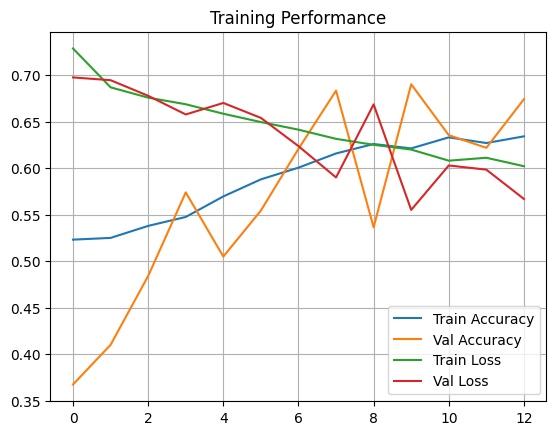

✅ Model saved to Google Drive!


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ✅ Step 8: Evaluate and show results
loss, acc = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {acc:.2f} | Loss: {loss:.2f}")

# ✅ Step 9: Plot Accuracy & Loss
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training Performance")
plt.grid()
plt.show()

# ✅ Step 10: Save the model to Drive (HDF5 or .keras format)
model.save('/content/drive/MyDrive/driver_behavior_bilstm_model.keras')  # Preferred
print("✅ Model saved to Google Drive!")